# Project: Identify Customer Segments

In this project, I apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that I use has been provided by the partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.


In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; **those over-represented clusters will be assumed to be part of the core userbase.** This information can then be used for **further applications, such as targeting for a marketing campaign.**

To start off with, I load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so I'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.


In [2]:
# Load in the general demographics data into a Pandas DataFrame.
azdias =pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';') 

# Load in the feature summary file into a Pandas DataFrame.
feat_info =pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';') 

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('Number of rows and columns respectively in Azdias:')
azdias.shape


Number of rows and columns respectively in Azdias:


(891221, 85)

In [4]:
print('Number of rows and columns repectively in Feat_Info:')
feat_info.shape

Number of rows and columns repectively in Feat_Info:


(85, 4)

In [5]:
print('Actual columns in Feat_Info')
feat_info.columns

Actual columns in Feat_Info


Index(['attribute', 'information_level', 'type', 'missing_or_unknown'], dtype='object')

In [6]:
print('Actual columns in Azdias:')
azdias.columns

Actual columns in Azdias:


Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [7]:
print('Actual data presentation in Azdias for the first 10:')
azdias.head(10)

Actual data presentation in Azdias for the first 10:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [8]:
print('Actual data presentation in Azdias for the last 10:')
azdias.tail(10)

Actual data presentation in Azdias for the last 10:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891211,-1,3,1,2.0,3,2,4,3,3,2,...,1.0,4.0,2.0,0.0,2.0,3.0,2.0,3.0,5.0,5.0
891212,-1,4,1,1.0,3,1,5,1,1,5,...,1.0,3.0,3.0,2.0,5.0,4.0,1.0,3.0,9.0,5.0
891213,-1,4,2,5.0,3,3,3,5,3,2,...,2.0,4.0,2.0,1.0,2.0,5.0,5.0,3.0,4.0,4.0
891214,-1,1,2,4.0,1,5,2,3,3,4,...,1.0,4.0,3.0,2.0,5.0,5.0,2.0,3.0,7.0,3.0
891215,-1,2,2,6.0,1,5,2,4,5,4,...,2.0,4.0,2.0,1.0,2.0,4.0,4.0,2.0,5.0,2.0
891216,-1,3,2,5.0,1,4,2,5,4,4,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,-1,2,1,4.0,3,3,3,2,2,3,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,-1,2,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,-1,1,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,-1,4,1,1.0,4,2,5,2,1,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


In [9]:
print('Actual data presentation in Feat_Info for the first 10:')
feat_info.head(10)

Actual data presentation in Feat_Info for the first 10:


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [10]:
print('Actual data presentation in Feat_Info for the last 10:')
feat_info.tail(10)

Actual data presentation in Feat_Info for the last 10:


,attribute,information_level,type,missing_or_unknown
75,PLZ8_ANTG1,macrocell_plz8,ordinal,[-1]
76,PLZ8_ANTG2,macrocell_plz8,ordinal,[-1]
77,PLZ8_ANTG3,macrocell_plz8,ordinal,[-1]
78,PLZ8_ANTG4,macrocell_plz8,ordinal,[-1]
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"
84,RELAT_AB,community,ordinal,"[-1,9]"


In [11]:
print('Description of the Azdias data:')
azdias.describe()

Description of the Azdias data:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [12]:
print('Description of the Feat_Info data:')
feat_info.describe()

Description of the Feat_Info data:


,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,LP_LEBENSPHASE_GROB,person,ordinal,[-1]
freq,1,43,49,26


In [13]:
print(feat_info.describe)

<bound method NDFrame.describe of                 attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numer

In [14]:
print(feat_info['missing_or_unknown'].dtypes)
print('type of data of missing_or_unknown is: ',type(feat_info.missing_or_unknown[0]))

object
type of data of missing_or_unknown is:  <class 'str'>


In [15]:
#checking the variance of the columns
print(azdias.var())

AGER_TYP                      1.436939
ALTERSKATEGORIE_GROB          1.142280
ANREDE_KZ                     0.249512
CJT_GESAMTTYP                 2.544092
FINANZ_MINIMALIST             1.745186
FINANZ_SPARER                 2.145489
FINANZ_VORSORGER              1.748039
FINANZ_ANLEGER                2.339684
FINANZ_UNAUFFAELLIGER         2.210369
FINANZ_HAUSBAUER              1.831280
FINANZTYP                     3.951651
GEBURTSJAHR              953715.432633
GFK_URLAUBERTYP              12.430724
GREEN_AVANTGARDE              0.157956
HEALTH_TYP                    1.610517
LP_LEBENSPHASE_FEIN         159.185730
LP_LEBENSPHASE_GROB          14.865955
LP_FAMILIE_FEIN              15.417294
LP_FAMILIE_GROB               3.085424
LP_STATUS_FEIN               11.732715
LP_STATUS_GROB                2.173603
NATIONALITAET_KZ              0.344139
PRAEGENDE_JUGENDJAHRE        23.469492
RETOURTYP_BK_S                2.009990
SEMIO_SOZ                     3.789112
SEMIO_FAM                

In [16]:
print(azdias.dtypes)

AGER_TYP                   int64
ALTERSKATEGORIE_GROB       int64
ANREDE_KZ                  int64
CJT_GESAMTTYP            float64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
FINANZTYP                  int64
GEBURTSJAHR                int64
GFK_URLAUBERTYP          float64
GREEN_AVANTGARDE           int64
HEALTH_TYP                 int64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
LP_FAMILIE_FEIN          float64
LP_FAMILIE_GROB          float64
LP_STATUS_FEIN           float64
LP_STATUS_GROB           float64
NATIONALITAET_KZ           int64
PRAEGENDE_JUGENDJAHRE      int64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int64
          

In [17]:
print(feat_info.dtypes)

attribute             object
information_level     object
type                  object
missing_or_unknown    object
dtype: object


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. I will use this file to help in making cleaning decisions during this stage of the project. First of all, I assess the demographics data in terms of missing data. 

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. I then convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [18]:
#As a result of the data type of missing_or_unknown being a string of list, it is then converted into a list.
feat_info['missing_or_unknown']=feat_info['missing_or_unknown'].apply(lambda x:x[1:-1].split(','))

print('type of data of missing_or_unknown is: ',type(feat_info.missing_or_unknown[0]))

type of data of missing_or_unknown is:  <class 'list'>


In [19]:
print(feat_info.describe)

<bound method NDFrame.describe of                 attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical            [-1, 0]
1    ALTERSKATEGORIE_GROB            person      ordinal         [-1, 0, 9]
2               ANREDE_KZ            person  categorical            [-1, 0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numer

**Having converted the string missing_or_unknown column into a list, the missing/unknown values can then be converted into NaNs**

In [20]:
# Identify missing or unknown data values and convert them to NaNs.
for attr,miss_unkn_value in zip(feat_info['attribute'],feat_info['missing_or_unknown']):
    if len(miss_unkn_value)>0 and miss_unkn_value!=['']:
        for value in miss_unkn_value:
            if value.isnumeric() or value.lstrip('-').isnumeric():
                value=int(value)
            azdias.loc[azdias[attr]==value,attr]=np.nan


In [21]:
#check the conversion
print('Overview after converting the missing values into NaNs:')
azdias.head(10)

Overview after converting the missing values into NaNs:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1.0,3.0,3.0,3.0,4.0,1.0,3.0,2.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2.0,4.0,2.0,4.0,2.0,3.0,5.0,4.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


**~Discussion**

**From the above representation, the missing/unknown values have been converted into NaNs**

In [22]:
#to find the total number of missing values after conversion into NaNs
print(azdias.isnull().sum())
print('\nThe total no. of missing values after conversion to NaNs is: ',azdias.isnull().sum().sum())

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

**~Discussion**

**There is an increasing number of total missing values in azdias data from 4,896,838 to 8,373,929. This is because, looking at the feat_info data (missing_unknown values are encoded as a series of string of list), which have thereby been converted into NaNs values, hence, increasing the total number of missing values.**

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [23]:
#Perform an assessment of how much missing data there is in each column of the dataset

total_missing_cols=azdias.isnull().sum()[azdias.isnull().sum()>0]
print('The total number of missing values after re-encoding to NaNs in each column is:\n{}'.format(total_missing_cols))
total_missing_cols=total_missing_cols[total_missing_cols>0]/[azdias.shape[0]]*100

The total number of missing values after re-encoding to NaNs in each column is:
AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
CJT_GESAMTTYP              4854
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SHOPPER_TYP              111196
SOHO_KZ                   73499
TITEL_KZ                 889061
VERS_TYP                 111196
ALTER_HH                 310267
ANZ_PERSONEN              73499
ANZ_TITEL                 73499
HH_EINKOMMEN_SCORE        18348
KK_KUNDENTYP             584612
W_KEIT_KIND_HH           147988
WOHNDAUER_2008            73499
ANZ_HAUSHALTE_AKTIV       99611
ANZ_HH_TITEL              97008
GEBAEUDETYP             

**~Discussion**

**From the above analysis, the length (count) of columns in the Azdias data that consist of missing data is 61 out of the 85, therefore, this implies that only 24 columns do not contain missing values.**

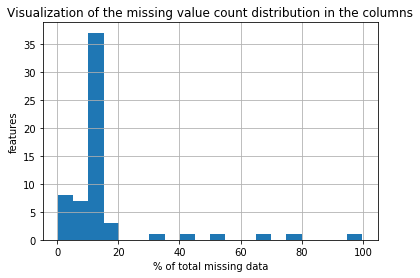

In [24]:
# using Matplotlib's hist() function to visualize the distribution
plt.hist(total_missing_cols,bins=20,orientation='vertical')
plt.xlabel('% of total missing data')
plt.ylabel('features')
plt.title('Visualization of the missing value count distribution in the columns')
plt.grid(True)
plt.show()

**~Discussion**

**From the histogram plot, surpassing 20% seem to be outlier points in the data. Literally counting them totals to 6 points**

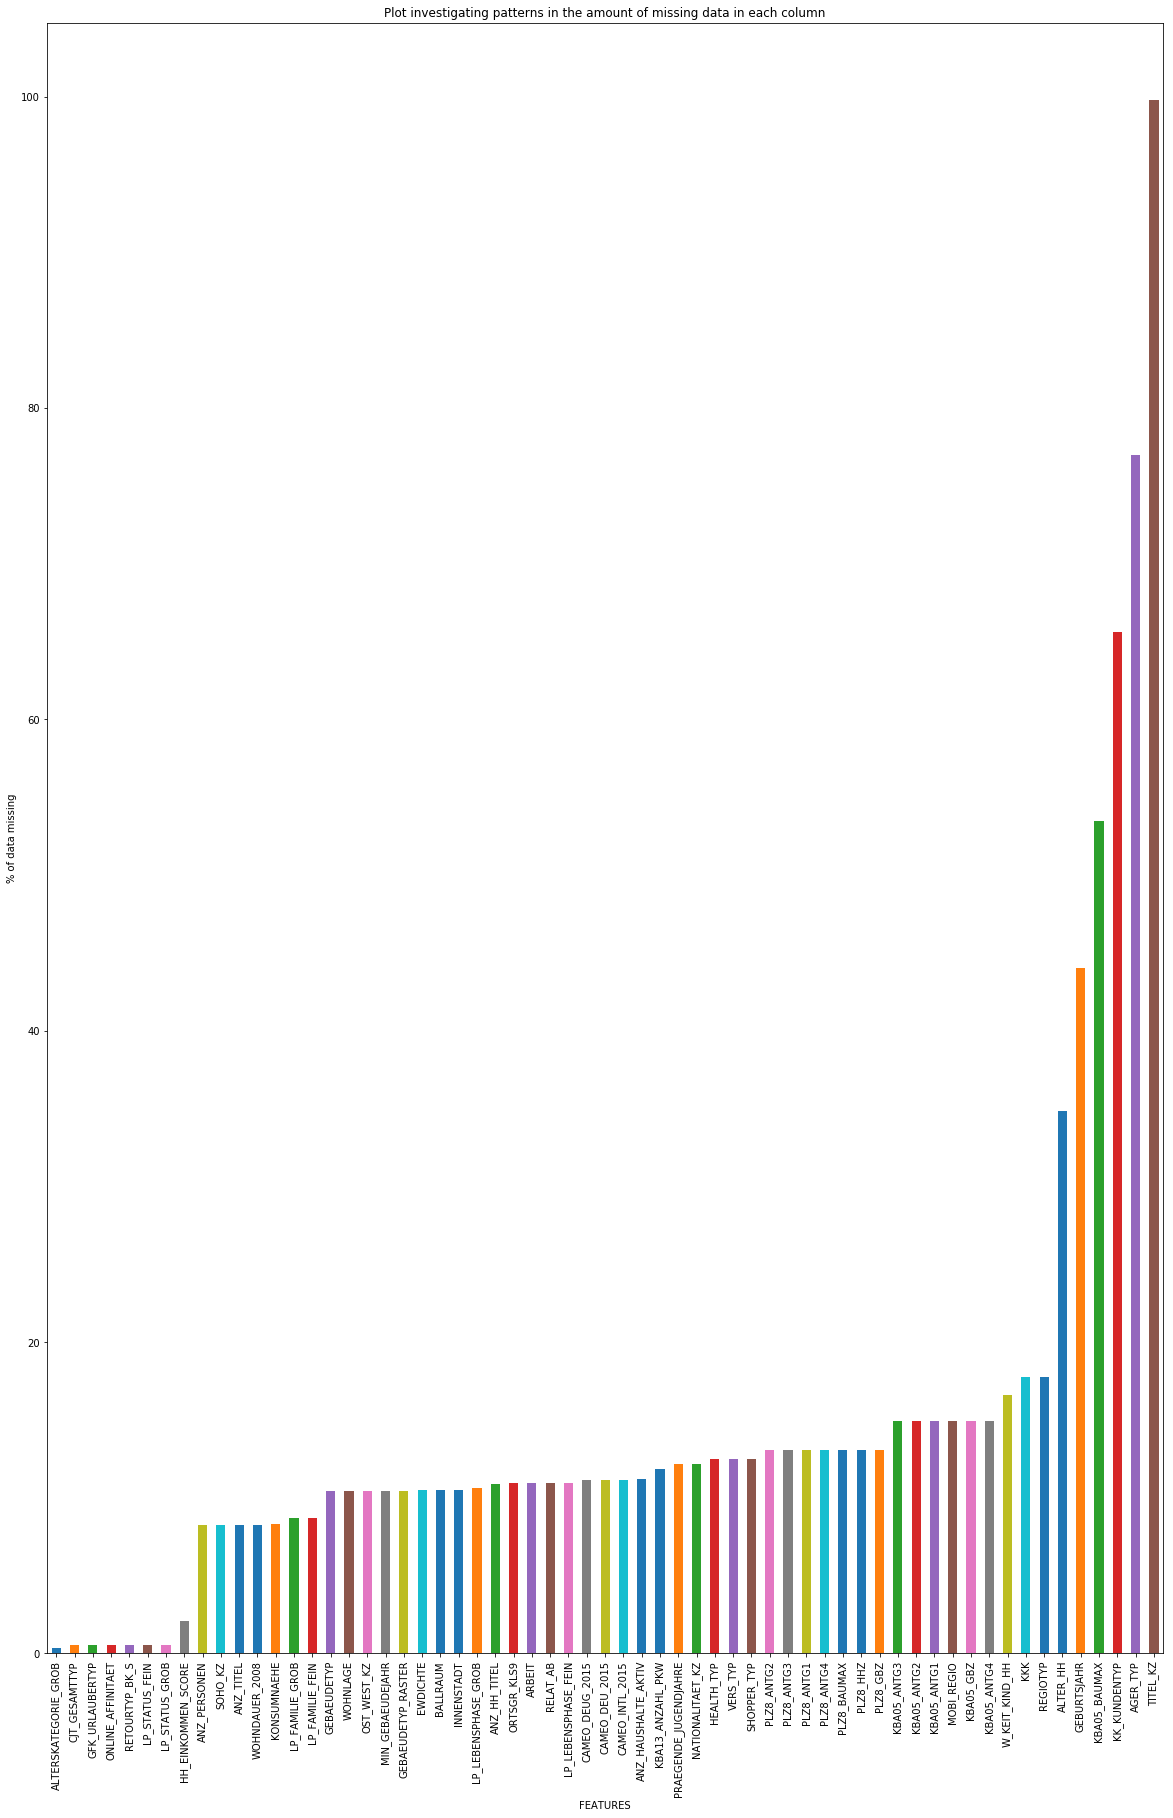

In [25]:
#investigate patterns in the amount of missing data in each column.

total_missing_cols.sort_values(inplace=True)
total_missing_cols.plot.bar(figsize=(20,30))
plt.title('Plot investigating patterns in the amount of missing data in each column')
plt.ylabel('% of data missing')
plt.xlabel('FEATURES')
plt.show()

**~Discussion**

**From the plot above investigating the patterns that occur in the columns having missing data, it appears that when above 30% of missing data, there are only 6 features, which I recommend to be dropped as outliers; this is because when dealing with missing/unknown values, dropping them is considered as the last option because of the sensitivity of the task (one could be dropping what is the significant feature for the algorithm). Because of this I will choose the lowest limit threshold as 20%**

In [26]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outlier_col_removal=[colm for colm in azdias.columns if(azdias[colm].isnull().sum()/azdias.shape[0]) *100>20]               
outlier_removal_no=len(outlier_col_removal)
print('The total number of outliers removed:{}'.format(outlier_removal_no))
print(outlier_col_removal)

azdias.drop(outlier_col_removal,axis=1,inplace=True)
print('Columns remaining after removing the outliers: {}'.format(azdias.shape[1]))


The total number of outliers removed:6
['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
Columns remaining after removing the outliers: 79


**~Discussion**

**The total number of columns in the Azdias data consisted of 85 columns, 61 of the had missing values; after the analysis to determine the outliers, 6 columns were removed namely: 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'; leaving behind 79 columns.**

#### Discussion 1.1.2: Assess Missing Data in Each Column

**In regards to the amount of missing data, the majority of the columns features have less missing features as compared to the ones with more missing features. In this case, the limit threshold of missing data is 20%; therefore, 6 features have surpassed this mark,hence have been removed from the data, leaving behind 79 column features.**

**In response to patterns in the missing data; some features have less missing data while others have a significant amount of missing data of upto 90% and above.**

**Therefore, the columns removed are namely: GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, KBA05_BAUMAX; six columns in total having in this case more than 20% of missing data.**

#### Step 1.1.3: Assess Missing Data in Each Row

Now, I'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, I see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, I should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what I observe in your comparison, this will have implications on how I approach my conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special.**Either way, for this project, I continue your analysis for now using just the subset of the data with few or no missing values.**

In [27]:
missing_rws_sum=azdias.isnull().sum(axis=1)
missing_rws_sum.sort_values(ascending=False)
print('The maximum number of missing values in rows is:',missing_rws_sum.max())
print('The total number of missing values in rows is:\n',missing_rws_sum.sum())
print('The number of missing values in each row is:\n',missing_rws_sum)

The maximum number of missing values in rows is: 49
The total number of missing values in rows is:
 5035304
The number of missing values in each row is:
 0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64


The total number of rows is: 891221 
The total number of rows having missing data is: 268012 
The total number of rows without missing data is: 623209


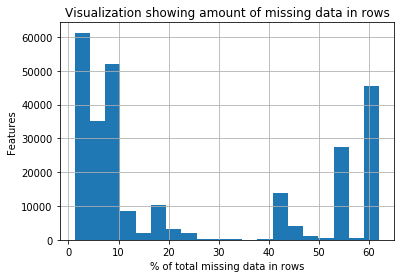

In [28]:
#How much data is missing in each row of the dataset?
all_rows=azdias.isnull().sum(axis=1)
missing_data_rows=azdias.isnull().sum(axis=1)[azdias.isnull().sum(axis=1)>0]
print('The total number of rows is: {} '.format(len(all_rows)))
print('The total number of rows having missing data is: {} '.format(len(missing_data_rows)))
print('The total number of rows without missing data is: {}'.format(len(all_rows)-len(missing_data_rows)))

#Visualization using plt() method
missing_data_plt=missing_data_rows/(azdias.shape[1])*100
missing_data_plt.sort_values(ascending=False,inplace=True)

plt.hist(missing_data_plt,bins=20)
plt.title('Visualization showing amount of missing data in rows')
plt.xlabel('% of total missing data in rows')
plt.ylabel('Features')
plt.grid(True)
plt.show()

**~Discussion**

**From the above plot, it is observed that the total number of rows is 891,221; and those that contain missing data amount to 268,012 rows. It is also observed that the outlier region begins at approximately 37% of the total missing data in rows.**

In [29]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
all_rows_plt=all_rows/(azdias.shape[1])
outlier_lim=0.37
azdias=azdias.assign(row_missing=pd.Series(all_rows_plt.values))

#data splits
above_lim=azdias[azdias['row_missing']>=outlier_lim]
below_lim=azdias[azdias['row_missing']<=outlier_lim]

#print statements
print('{} instances in above_lim data split'.format(above_lim.shape[0]))
print('{} instances in below_lim data split'.format(below_lim.shape[0]))


93160 instances in above_lim data split
798061 instances in below_lim data split


**~Discussion**

**2 data splits have been created namely:**

**1.) above_lim=93,160 instances**

**2.) below_lim=798,061 instances**

In [30]:
below_lim.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,row_missing
count,795258.000000,798061.000000,793316.000000,798061.000000,798061.000000,798061.000000,798061.000000,798061.000000,798061.000000,798061.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793834.000000,793935.000000,793834.000000,798061.000000
mean,2.795412,1.521485,3.502893,3.058917,2.716047,3.432892,2.840955,2.658348,3.114102,3.797751,...,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166687,5.293396,3.071035,0.016086
std,1.018409,0.499538,1.537612,1.377577,1.485090,1.376866,1.472782,1.399530,1.408109,2.084705,...,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999070,2.303377,1.360535,0.038752
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,...,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000,0.000000
50%,3.000000,2.000000,4.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,4.000000,...,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000,0.000000
75%,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,6.000000,...,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000,0.000000
max,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000,0.367089


['ZABEOTYP', 'FINANZTYP', 'SEMIO_RAT', 'SEMIO_PFLICHT', 'SEMIO_KRIT', 'FINANZ_VORSORGER']


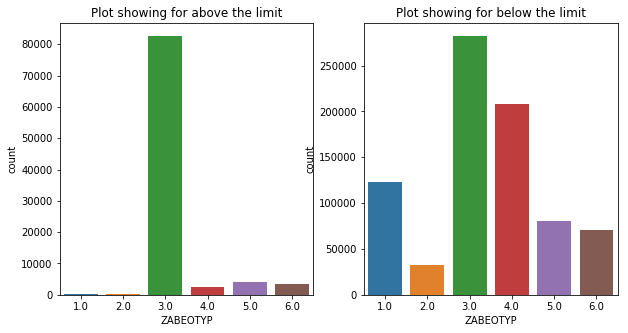

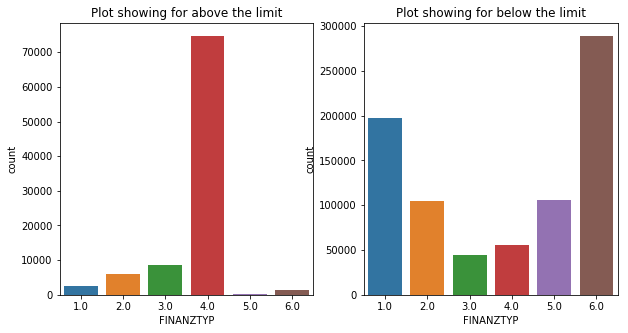

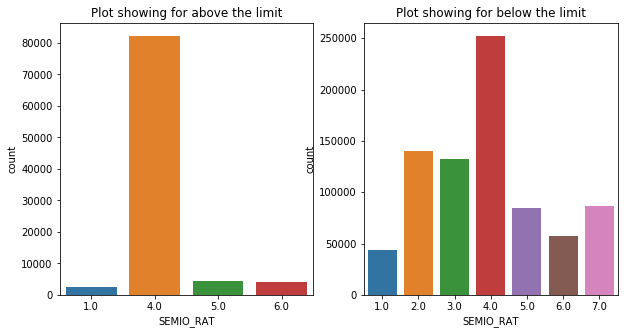

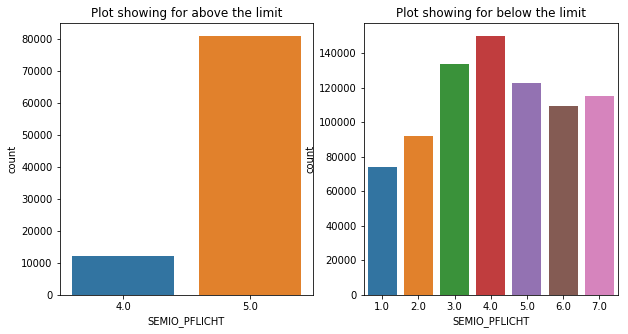

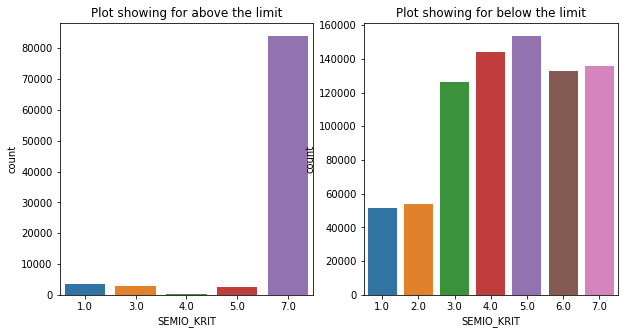

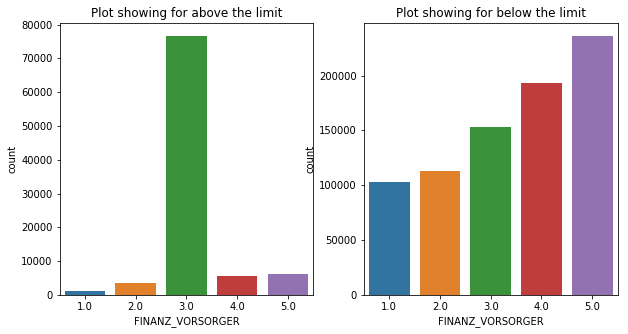

In [31]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
np.random.seed(700)
selected_clms=np.random.choice(azdias.dropna(axis=1).columns,6).tolist()
print(selected_clms)

#plotting using seaborn.countplot() method and the subplot() method
for clm in selected_clms:
    fig=plt.figure(figsize=(10,5))
    axis1=fig.add_subplot(1,2,1)
    sns.countplot(above_lim[clm])
    
    axis2=fig.add_subplot(1,2,2)
    sns.countplot(below_lim[clm])
    
    axis1.title.set_text('Plot showing for above the limit')
    axis2.title.set_text('Plot showing for below the limit')
    
    
    plt.show()


#### Discussion 1.1.3: Assess Missing Data in Each Row

**From the above plot, there is a distinct difference between the two subplits namely: above_lim and below_lim, which in this case represent rows with many missing values and rows with few missing values respectively above a given limit; which in this case is approximately 37%.**

**Even though from the plot having different scales for the y-axis; it still shows a peculiar characteristic in that for those rows having many missing values (above_lim) there is a significant quantitative difference from those having few/no missing values(below_lim).**

**For this project, the data split 'below_lim' is used in the rest of the notebook**

In [32]:
print('{} rows and {} columns'.format(below_lim.shape[0],below_lim.shape[1]))

798061 rows and 80 columns


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, I need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, I perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether I will keep, drop, or re-encode each. Then, in the last part, I will create a new data frame with only the selected and engineered columns.


In [33]:
# How many features are there of each data type?
feat_info=feat_info[feat_info.attribute.isin(outlier_col_removal)==False]
print('data type and their total number in feat_info:\n',feat_info.type.value_counts())

data type and their total number in feat_info:
 ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64


**~Discussion**

**From the investigation of the categorical and mixed-type features, there are 49 ORDINAL type, 18 CATEGORICAL type, 6 NUMERIC type, 6 MIXED type.**

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, I would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, I perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [34]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
list_categorical=feat_info[feat_info['type']=='categorical'].attribute.tolist()
print('The categorical features are namely:\n{}'.format(list_categorical))


The categorical features are namely:
['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [35]:
list_categorical_multi=[]
list_categorical_binary=[]

for feature in list_categorical:
    if feature in below_lim.columns.tolist():
        if below_lim[feature].nunique()>2:
            list_categorical_multi.append(feature)
        else:
            list_categorical_binary.append(feature)

print('The multi subcategory includes:\n{}\n\n'.format(list_categorical_multi))
print('The binary subcategory includes:\n{}'.format(list_categorical_binary))

The multi subcategory includes:
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


The binary subcategory includes:
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']


In [36]:
#binary subcategory info
for feature in list_categorical_binary:
    print(feature,'\n',below_lim[feature].value_counts(),'\n')

ANREDE_KZ 
 2.0    416177
1.0    381884
Name: ANREDE_KZ, dtype: int64 

GREEN_AVANTGARDE 
 0    622836
1    175225
Name: GREEN_AVANTGARDE, dtype: int64 

SOHO_KZ 
 0.0    791344
1.0      6717
Name: SOHO_KZ, dtype: int64 

VERS_TYP 
 2.0    394238
1.0    367102
Name: VERS_TYP, dtype: int64 

OST_WEST_KZ 
 W    629520
O    168541
Name: OST_WEST_KZ, dtype: int64 



**~Discussion**
**From the analysis of the binary subcategory, it is seen that the feature 'OST_WEST_KZ' has non-numeric values: O,W; as a result of this, this feature will be reencoded.**

**In addition to that, the features 'ANREDE_KZ' and 'VERS_TYP' will be reencoded to 1,0**

In [37]:
# Re-encode categorical variable(s) to be kept in the analysis.
below_lim_1=below_lim.copy()
below_lim_1['OST_WEST_KZ'].replace(['W','O'],[1,0],inplace=True)
below_lim_1['ANREDE_KZ'].replace([2.0,1.0],[1,0],inplace=True)
below_lim_1['VERS_TYP'].replace([2.0,1.0],[1,0],inplace=True)

#check
for feature in list_categorical_binary:
    print(feature,'\n',below_lim_1[feature].value_counts(),'\n')


ANREDE_KZ 
 1.0    416177
0.0    381884
Name: ANREDE_KZ, dtype: int64 

GREEN_AVANTGARDE 
 0    622836
1    175225
Name: GREEN_AVANTGARDE, dtype: int64 

SOHO_KZ 
 0.0    791344
1.0      6717
Name: SOHO_KZ, dtype: int64 

VERS_TYP 
 1.0    394238
0.0    367102
Name: VERS_TYP, dtype: int64 

OST_WEST_KZ 
 1    629520
0    168541
Name: OST_WEST_KZ, dtype: int64 



In [38]:
#drop the multi subcategory
for feature in list_categorical_multi:
    below_lim_1=below_lim_1.drop(feature,axis=1)

In [39]:
print("Shape of dataframe is: rows: {} and columns: {}".format(below_lim_1.shape[0],below_lim_1.shape[1]))

Shape of dataframe is: rows: 798061 and columns: 67


#### Discussion 1.2.1: Re-Encode Categorical Features

**There were 18 total categorical features in the data; 5 of which were of binary data type and the other 13 were of a multi-level data type.**

**In regards to the categorical features, there were 3 main groups namely: 1.) Binary, 2.) Non-numeric binary and 3.) Multi-level.**

**All of the 13 multi-level categories were dropped, the 1 binary variable which is non-numeric was re-encoded. For the purpose of simplicity, the other 2 binary variable which had values 2.0 and 1.0 each, were re-encoded to 1 and 0 respectively.**

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention:

- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, I should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).


In [40]:
#viewing the mixed-type features
list_categorical_mixed=feat_info[feat_info['type']=='mixed'].attribute.tolist()
print('The mixed-type features include:\n{}'.format(list_categorical_mixed))

The mixed-type features include:
['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


In [41]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
print('The structure of PRAEGENDE_JUGENDJAHRE is as follows:\n{}'.format(below_lim_1['PRAEGENDE_JUGENDJAHRE'].value_counts()))
decade_var={
    0:[1,2],
    1:[3,4],
    2:[5,6,7],
    3:[8,9],
    4:[10,11,12,13],
    5:[14,15] 
           }
#function for the interval-type variable for decade
def decade_features(value):
    try:
        for feature,values in decade_var.items():
            if value in values:
                return feature
    except ValueError:
        return np.nan

movement_var={
    0:[2,4,6,7,9,11,13,15],
    1:[1,3,5,8,10,12,14]
            }    
#function for the binary variable for movement
def movement_features(value):
    try:
        for feature,values in movement_var.items():
            if value in values:
                return feature
        else:
            return 0
    except ValueError:
        return np.nan

The structure of PRAEGENDE_JUGENDJAHRE is as follows:
14.0    182983
8.0     141630
10.0     85808
5.0      84691
3.0      53845
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      20678
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64


In [42]:
#printing the results
below_lim_1['P_J_MOVEMENT_FEATURE']=below_lim_1['PRAEGENDE_JUGENDJAHRE'].apply(movement_features)
below_lim_1['P_J_DECADE_FEATURE']=below_lim_1['PRAEGENDE_JUGENDJAHRE'].apply(decade_features)

print('The structure of movement feature is as follows:\n{}'.format(below_lim_1['P_J_MOVEMENT_FEATURE'].value_counts()))
print('The structure of decade is as follows:\n{}'.format(below_lim_1['P_J_DECADE_FEATURE'].value_counts()))

The structure of movement feature is as follows:
1    594081
0    203980
Name: P_J_MOVEMENT_FEATURE, dtype: int64
The structure of decade is as follows:
5.0    225530
3.0    175200
4.0    151770
2.0    114353
1.0     74296
0.0     28157
Name: P_J_DECADE_FEATURE, dtype: int64


In [43]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
print('The structure of CAMEO_INTL_2015 is as follows:\n{}'.format(below_lim_1['CAMEO_INTL_2015'].value_counts()))

#function for  Wealth typology
def wealth_typology(value):
    try:
        if pd.isnull(value):
            return np.nan
        else:
            return int(str(value)[0])
    except ValueError:
        return np.nan

#function for Lifestage typology
def lifestage_typology(value):
    try:
        if pd.isnull(value):
            return np.nan
        else:
            return int(str(value[1]))
    except ValueError:
        return np.nan

The structure of CAMEO_INTL_2015 is as follows:
51    133694
41     92336
24     91157
14     62884
43     56672
54     45391
25     39626
22     33154
23     26750
13     26335
45     26132
55     23955
52     20542
31     19023
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64


In [44]:
#printing the results
below_lim_1['C_I_2015_WEALTH']=below_lim_1['CAMEO_INTL_2015'].apply(wealth_typology)
below_lim_1['C_I_2015_LIFESTAGE']=below_lim_1['CAMEO_INTL_2015'].apply(lifestage_typology)

print('The structure of variable wealth typology is as follows:\n{}\n'.format(below_lim_1['C_I_2015_WEALTH'].value_counts()))
print('The structure of variable lifestage typology is as follows:\n{}'.format(below_lim_1['C_I_2015_LIFESTAGE'].value_counts()))

The structure of variable wealth typology is as follows:
5.0    223582
2.0    190687
4.0    189960
1.0    119442
3.0     68192
Name: C_I_2015_WEALTH, dtype: int64

The structure of variable lifestage typology is as follows:
1.0    245053
4.0    232776
3.0    119692
5.0    117043
2.0     77299
Name: C_I_2015_LIFESTAGE, dtype: int64


In [45]:
below_lim_1=below_lim_1.drop(list_categorical_mixed,axis=1)


In [46]:
print('Remaining shape of the dataframe is: rows: {}, columns: {}'.format(below_lim_1.shape[0],below_lim_1.shape[1]))


Remaining shape of the dataframe is: rows: 798061, columns: 65


#### Discussion 1.2.2: Engineer Mixed-Type Features

**Of the 6 features in the mixed-type feature, 2 features namely:'CAMEO_INTL_2015' and 'PRAEGENDE_JUGENDJAHRE' underwent engineering steps.**

**For the 'PRAEGENDE_JUGENDJAHRE' creation of two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement was done and also for the 'CAMEO_INTL_2015' there was a break up of the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables.**

**Then the features namely: 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX', 'CAMEO_INTL_2015' and 'PRAEGENDE_JUGENDJAHRE' have been dropped, leaving behind the engineered features.**

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, I need to make sure that the data frame now only has the columns that I want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

I also made sure that for any new columns that I have engineered, that I've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, I excluded "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. 

In [47]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
if 'row_missing' in below_lim_1.columns:
    below_lim_1=below_lim_1.drop(['row_missing'],axis=1)
    
print('Feature successfully dropped.')
print('rows {}, columns {}'.format(below_lim_1.shape[0],below_lim_1.shape[1]))

Feature successfully dropped.
rows 798061, columns 64


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that I'll need to perform the same cleaning steps on the customer demographics data. In this substep, I come up with the function below to execute the main feature selection, encoding, and re-engineering steps I performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [48]:
def cleaning_data(data_f,data_f_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    #1. PREPROCESSING
    
    #1.1 Convert 'feat_info' from string to a list
    data_f_info['missing_or_unknown']=data_f_info['missing_or_unknown'].apply(lambda x:x[1:-1].split(','))
    
    #1.2 Convert missing values to NaNs
    for attr,miss_unkn_value in zip(data_f_info['attribute'],data_f_info['missing_or_unknown']):
        if len(miss_unkn_value)>0 and miss_unkn_value != ['']:
            for value in miss_unkn_value:
                if value.isnumeric() or value.lstrip('-').isnumeric():
                    value=int(value)
                data_f.loc[data_f[attr]==value,attr]=np.nan
                
    #CHECK: To find the total number of missing values after conversion to NaNs
    print('\nTotal missing values after conversion to NaNs is: {}'.format(data_f.isnull().sum().sum()))
    
    #1.3 Assessment of missing data in each column of the dataframe
    total_missing_cols=data_f.isnull().sum()[data_f.isnull().sum()>0]
    total_missing_cols=total_missing_cols[total_missing_cols>0]/[data_f.shape[0]]*100
    
    #1.4 Removing the outlier columns
    outlier_col_removal=['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    data_f.drop(outlier_col_removal,axis=1,inplace=True)
    
    #CHECK: Columns remaining after removing the outliers
    print('Number of columns remaining after removing the outliers: {}'.format(data_f.shape[1]))
    
    #1.5 Assessment of missing data in each row of the dataframe
    all_rows=data_f.isnull().sum(axis=1)
    missing_data_rows=data_f.isnull().sum(axis=1)[data_f.isnull().sum(axis=1)>0]
    missing_data_plt=missing_data_rows/(data_f.shape[1])*100
    all_rows_plt=all_rows/(data_f.shape[1]) 
    outlier_lim=0.37
    data_f=data_f.assign(row_missing=pd.Series(all_rows_plt.values))
        
    #data split according to rows
    above_lim_f=data_f[data_f['row_missing']>=outlier_lim]
    below_lim_f=data_f[data_f['row_missing']<=outlier_lim]
    print('{} instances in above_lim_f data split'.format(above_lim_f.shape[0]))
    print('{} instances in below_lim_f data split'.format(below_lim_f.shape[0]))
    
    
    print("{} rows and {} columns".format(below_lim_f.shape[0],below_lim_f.shape[1]))
    
    #1.6 Select and reencode features
      # Removing the outlier columns in feat_info
    data_f_info=data_f_info[data_f_info.attribute.isin(outlier_col_removal)==False]
      # Re-Encode categorical features
         #view of categorical features
    list_categorical=data_f_info[data_f_info['type']=='categorical'].attribute.tolist()
         #assessment of binary and multi-level subcategories
    list_categorical_multi=[]
    list_categorical_binary=[]
    for feature in list_categorical:
        if feature in below_lim_f.columns.tolist():
            if below_lim_f[feature].nunique()>2:
                list_categorical_multi.append(feature)
            else:
                list_categorical_multi.append(feature)
                
    #re-encoding
    below_lim_f1=below_lim_f.copy()
    below_lim_f1['OST_WEST_KZ'].replace(['W','O'],[1,0],inplace=True)
    below_lim_f1['ANREDE_KZ'].replace([2.0,1.0],[1,0],inplace=True)
    below_lim_f1['VERS_TYP'].replace([2.0,1.0],[1,0],inplace=True)
         
        #drop the 'multi' subcategory
    for feature in list_categorical_multi:
        below_lim_f1=below_lim_f1.drop(feature,axis=1)
        
    print("Shape of the dataframe is: rows: {} and columns: {}".format(below_lim_f1.shape[0],below_lim_f1.shape[1]))
        
        
    #1.7 Engineer mixed-type features
    list_categorical_mixed=data_f_info[data_f_info['type']=='mixed'].attribute.tolist()
    
    decade_var={
        0:[1,2],
        1:[3,4],
        2:[5,6,7],
        3:[8,9],
        4:[10,11,12,13],
        5:[14,15]
            }
    
    #function for the interval-type variable for decade
    def decade_features(value):
        try:
            for feature,values in decade_var.items():
                if value in values:
                    return feature
        except ValueError:
            return np.nan
        
    movement_var={
        0:[2,4,6,7,9,11,13,15],
        1:[1,3,5,8,10,12,14]
    }
    
    #function for the binary variable for movement
    def movement_features(value):
        try:
            for feature,values in movement_var.items():
                if value in values:
                    return feature
            else:
                return 0
        except ValueError:
            return np.nan
        
    below_lim_f1['P_J_MOVEMENT_FEATURE']=below_lim_f1['PRAEGENDE_JUGENDJAHRE'].apply(movement_features)
    below_lim_f1['P_J_DECADE_FEATURE']=below_lim_f1['PRAEGENDE_JUGENDJAHRE'].apply(decade_features)
    
    #function for wealth typology
    def wealth_typology(value):
        try:
            if pd.isnull(value):
                return np.nan
            else:
                return int(str(value)[0])
        except ValueError:
            return np.nan
    
    #function for lifestage typology
    def lifestage_typology(value):
        try:
            if pd.isnull(value):
                return np.nan
            else:
                return int(str(value)[1])
        except ValueError:
            return np.nan
        
    below_lim_f1['C_I_2015_WEALTH']=below_lim_f1['CAMEO_INTL_2015'].apply(wealth_typology)
    below_lim_f1['C_I_2015_LIFESTAGE']=below_lim_f1['CAMEO_INTL_2015'].apply(lifestage_typology)
    
    below_lim_f1=below_lim_f1.drop(list_categorical_mixed,axis=1)
    
    print('Remaining shape of the dataframe is: rows: {}, columns: {}'.format(below_lim_f1.shape[0],below_lim_f1.shape[1]))
    
    #complete feature selection
    #if 'row_missing' in data_f_1.columns:
        #data_f_2=data_f_1.drop(['row_missing'],axis=1)
    #else:
        #data_f_2=data_f_1.copy()
            
    #check final of rows and columns of the dataframe
    #print('There are {} rows and {} columns after passing the dataframe to the cleaning function'.format(data_f_2.shape[0],data_f_2.shape[1]))
    
    
    return below_lim_f1

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before I apply dimensionality reduction techniques to the data, I need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, I'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help navigate to all of the classes and functions that I'll need. In this substep, I'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to the data, I made sure that I've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. I might also try a more complicated procedure where I temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, I can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Also, I keep the fit sklearn objects handy, since I'll be applying them to the customer demographics data towards the end of the project.

In [49]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
print('The total number of missing values is: {}\n'.format(below_lim_1.isnull().sum().sum()))
print('Overview of the missing values is:\n {}'.format(below_lim_1.isnull().sum()[below_lim_1.isnull().sum()>0]))


The total number of missing values is: 734506

Overview of the missing values is:
 ALTERSKATEGORIE_GROB     2803
HEALTH_TYP              36721
RETOURTYP_BK_S           4745
VERS_TYP                36721
W_KEIT_KIND_HH          59302
ANZ_HAUSHALTE_AKTIV      6460
ANZ_HH_TITEL             3857
KONSUMNAEHE                71
KBA05_ANTG1             40164
KBA05_ANTG2             40164
KBA05_ANTG3             40164
KBA05_ANTG4             40164
KBA05_GBZ               40164
BALLRAUM                  592
EWDICHTE                  592
INNENSTADT                592
GEBAEUDETYP_RASTER          7
KKK                     64906
MOBI_REGIO              40164
ONLINE_AFFINITAET        4745
REGIOTYP                64906
KBA13_ANZAHL_PKW        12641
PLZ8_ANTG1              23355
PLZ8_ANTG2              23355
PLZ8_ANTG3              23355
PLZ8_ANTG4              23355
PLZ8_HHZ                23355
PLZ8_GBZ                23355
ARBEIT                   4227
ORTSGR_KLS9              4126
RELAT_AB         

In [50]:
#using interpolation method to replace the missing values
for clm in below_lim_1.columns:
    below_lim_1[clm]=below_lim_1[clm].interpolate(limit_direction='both')
    
print('Overview of the missing values after interpolation method is:\n {}'.format(below_lim_1.isnull().sum()[below_lim_1.isnull().sum()>0]))

Overview of the missing values after interpolation method is:
 Series([], dtype: int64)


In [51]:
# Apply feature scaling to the general population demographics data.
scaler=StandardScaler()
below_lim_scaled=pd.DataFrame(scaler.fit_transform(below_lim_1),index=below_lim_1.index,columns=below_lim_1.columns)

In [52]:
below_lim_scaled.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,P_J_MOVEMENT_FEATURE,P_J_DECADE_FEATURE,C_I_2015_WEALTH,C_I_2015_LIFESTAGE
count,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,...,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05
mean,5.520086e-17,-4.195710e-17,-1.162868e-16,1.379843e-16,1.217268e-16,-6.495004e-17,-1.572512e-16,-1.217980e-16,-3.712703e-18,1.681845e-16,...,-6.819977e-18,1.650417e-16,-9.441127e-17,5.787186e-18,5.986177e-17,1.146976e-16,5.106969e-17,-9.505231e-17,2.260564e-17,-7.193918e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.764426e+00,-1.043935e+00,-1.494594e+00,-1.155518e+00,-1.766980e+00,-1.249985e+00,-1.184933e+00,-1.501377e+00,-5.304094e-01,-1.606548e+00,...,-9.670167e-01,-2.700045e+00,-2.156816e+00,-2.170570e+00,-1.866290e+00,-1.524078e+00,-1.706589e+00,-2.307517e+00,-1.546976e+00,-1.264290e+00
25%,-7.816326e-01,-1.043935e+00,-7.686810e-01,-1.155518e+00,-1.040692e+00,-1.249985e+00,-1.184933e+00,-7.912046e-01,-5.304094e-01,-2.669205e-01,...,-9.670167e-01,-6.326904e-01,-3.455392e-01,-1.661031e-01,-5.620772e-01,-7.881820e-01,-1.706589e+00,-9.229098e-01,-8.629210e-01,-1.264290e+00
50%,2.011604e-01,9.579144e-01,-4.276828e-02,1.912029e-01,4.118838e-01,1.079899e-01,-4.704071e-01,-8.103182e-02,-5.304094e-01,-2.669205e-01,...,4.176634e-01,-1.158517e-01,-3.455392e-01,-1.661031e-01,-1.273395e-01,-5.228611e-02,5.859640e-01,-2.306062e-01,5.051899e-01,8.524636e-02
75%,1.183953e+00,9.579144e-01,6.831445e-01,8.645632e-01,1.138172e+00,7.869776e-01,9.586455e-01,6.291410e-01,-5.304094e-01,1.072707e+00,...,4.176634e-01,4.009869e-01,5.600989e-01,8.361303e-01,7.421358e-01,6.836098e-01,5.859640e-01,1.154001e+00,1.189245e+00,7.600144e-01
max,1.183953e+00,9.579144e-01,1.409057e+00,1.537924e+00,1.138172e+00,1.465965e+00,1.673172e+00,1.339314e+00,1.885336e+00,1.072707e+00,...,1.802344e+00,1.434664e+00,1.465737e+00,1.838364e+00,1.611611e+00,1.419506e+00,5.859640e-01,1.154001e+00,1.189245e+00,1.434782e+00


### Discussion 2.1: Apply Feature Scaling

**First of all, in this section, all the missing values have been filled with the interpolation method; making it possible to apply the sklearn feature scaling technique. The features have then been scaled to a standard deviation of 1 and the average to 0.**

### Step 2.2: Perform Dimensionality Reduction

On the scaled data, I'm now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, I should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what I find, select a value for the number of transformed features I'll retain for the clustering part of the project.
- Once I've made a choice for the number of components to keep, I made sure I re-fit a PCA instance to perform the decided-on transformation.

In [53]:
# Apply PCA to the data.
pca=PCA()
below_lim_pca=pca.fit_transform(below_lim_scaled)
print(below_lim_pca)

[[ 3.90382607 -2.60455124 -2.89091755 ...,  0.17456924 -0.086248
  -0.07314823]
 [-0.87829662  0.27434285 -3.11598027 ..., -0.01107512  0.06414065
   0.064972  ]
 [-3.96132427  1.18814138 -0.8117005  ...,  0.11437951 -0.37002644
  -0.53286726]
 ..., 
 [-0.94694192 -3.36065863 -2.95956762 ..., -0.09943336 -0.03178163
  -0.1185888 ]
 [ 5.88368088 -3.33944483  2.33323759 ...,  0.29711464  0.14390543
   0.01691624]
 [-0.7238455   1.08406039  3.1394965  ...,  0.97987104 -0.08925031
  -0.1703001 ]]


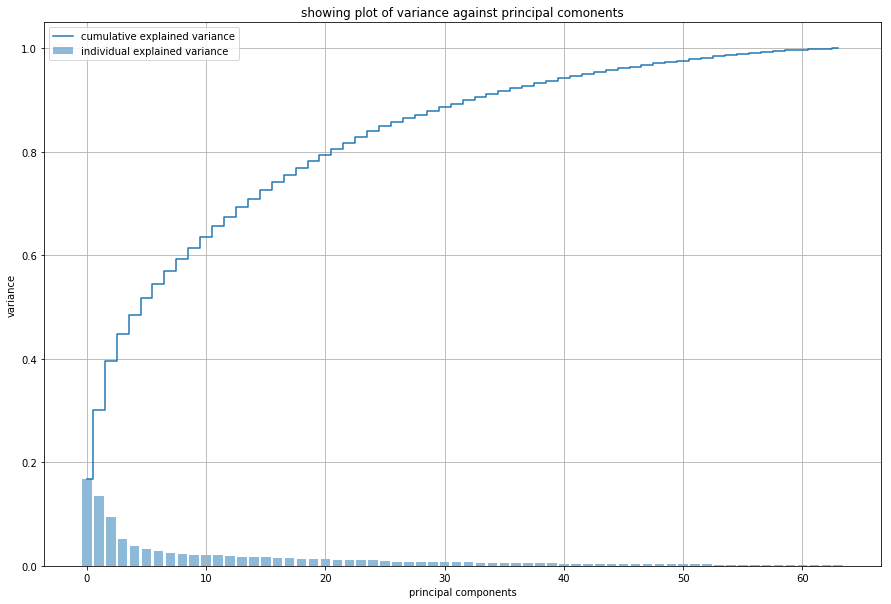

In [54]:
# Investigate the variance accounted for by each principal component.
exp=pca.explained_variance_ratio_
cse=np.cumsum(exp)

#plot
plt.figure(figsize=(15,10))
plt.bar(range(0,len(exp)),exp,alpha=0.5,align='center',label='individual explained variance')
plt.step(range(0,len(cse)),cse,where='mid',label='cumulative explained variance')
plt.ylabel('variance')
plt.xlabel('principal components')
plt.title('showing plot of variance against principal comonents')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [55]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca=PCA(n_components=30,random_state=45)
below_lim_pca=pca.fit_transform(below_lim_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

**A plot showing the variance accounted for by each principal component is used in this case to determine the number of components to be used for this case, which in this case have been reduced to 30 principal components which account for a variance of approximately 87%.**

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, I map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- I investigated and interpreted feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

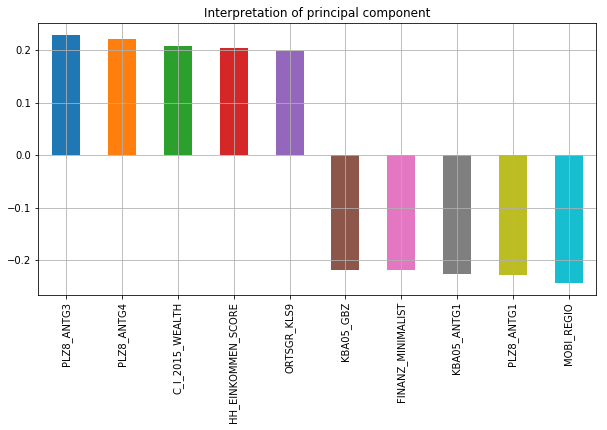

PLZ8_ANTG3            0.2282
PLZ8_ANTG4            0.2213
C_I_2015_WEALTH       0.2079
HH_EINKOMMEN_SCORE    0.2038
ORTSGR_KLS9           0.1994
KBA05_GBZ            -0.2181
FINANZ_MINIMALIST    -0.2184
KBA05_ANTG1          -0.2261
PLZ8_ANTG1           -0.2276
MOBI_REGIO           -0.2428
Name: 0, dtype: float64

In [56]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def interpret_pc(data_f,pca,comp_count):
    pc_interpret=pd.DataFrame(np.round(pca.components_,4),columns=data_f.keys()).iloc[comp_count-1]
    pc_interpret.sort_values(ascending=False,inplace=True)
    pc_interpret=pd.concat([pc_interpret.head(5),pc_interpret.tail(5)])
    
    #plotting the results
    pc_interpret.plot.bar(figsize=(10,5),title='Interpretation of principal component')
    plt.grid(True)
    plt.show()
    
    return pc_interpret

#component 1
interpret_pc(below_lim_scaled,pca,1)



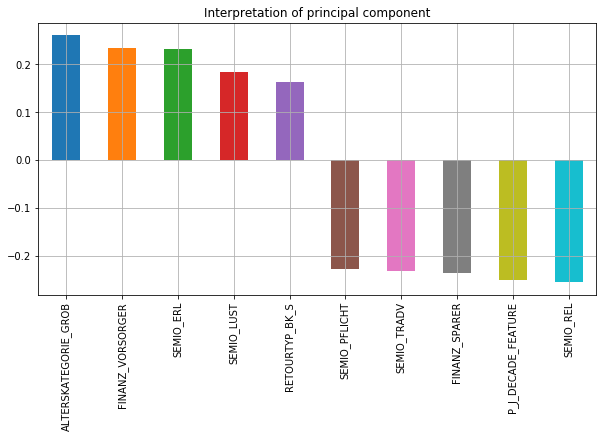

ALTERSKATEGORIE_GROB    0.2609
FINANZ_VORSORGER        0.2339
SEMIO_ERL               0.2313
SEMIO_LUST              0.1842
RETOURTYP_BK_S          0.1634
SEMIO_PFLICHT          -0.2288
SEMIO_TRADV            -0.2320
FINANZ_SPARER          -0.2371
P_J_DECADE_FEATURE     -0.2502
SEMIO_REL              -0.2557
Name: 1, dtype: float64

In [57]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
interpret_pc(below_lim_scaled,pca,2)

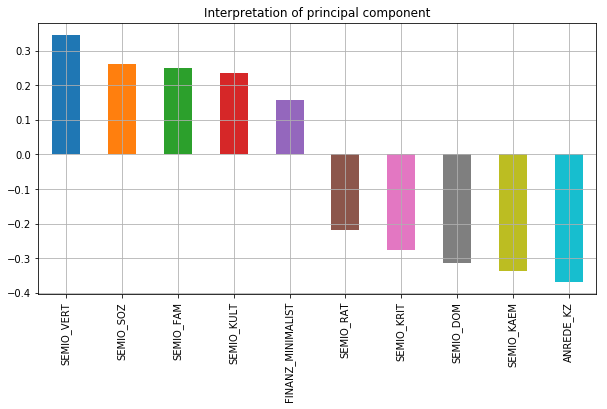

SEMIO_VERT           0.3455
SEMIO_SOZ            0.2623
SEMIO_FAM            0.2499
SEMIO_KULT           0.2354
FINANZ_MINIMALIST    0.1564
SEMIO_RAT           -0.2186
SEMIO_KRIT          -0.2763
SEMIO_DOM           -0.3151
SEMIO_KAEM          -0.3377
ANREDE_KZ           -0.3691
Name: 2, dtype: float64

In [58]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
interpret_pc(below_lim_scaled,pca,3)

### Discussion 2.3: Interpret Principal Components

**Based on the first cluster points, on the most positive side is 'PLZ8_ANTG3' and the most negative side is 'MOBI REGIO'**

**Based on the second cluster points, on the most +veside is 'ALTERSKATEGORIE_GROB' and the most negative side is 'SEMIO_REL'**

**Based on the third cluster points, on the most positive side is 'SEMIO_VERT' and the most negative side is 'ANREDE_KZ'**

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

I've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, I apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. I also made sure that I also obtain the cluster assignments for the general demographics data, since I'll be using them in the final Step 3.3.

In [59]:
# Over a number of different cluster counts...
def kmeans_clustering(data_f,center):
    # run k-means clustering on the data and...
    kmeans_model=(KMeans(n_clusters=center)).fit(data_f)
    # compute the average within-cluster distances.
    score=np.abs(kmeans_model.score(data_f))
    return score

In [60]:
scores_list=[]
centres_list=list(range(1,15,2))
for center in centres_list:
    scores_list.append(kmeans_clustering(below_lim_pca,center))

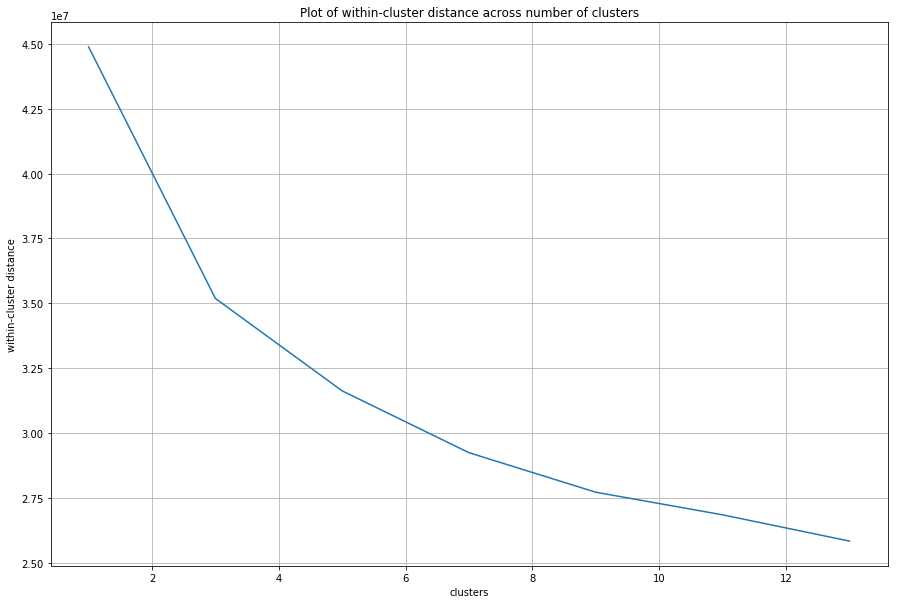

In [61]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(15,10))
plt.plot(centres_list,scores_list)
plt.xlabel('clusters')
plt.ylabel('within-cluster distance')
plt.title('Plot of within-cluster distance across number of clusters')
plt.grid(True)
plt.show()



In [62]:
kmeans = KMeans(n_clusters=9)
general_model = kmeans.fit(below_lim_pca)

In [63]:
kmeans_model_1 = general_model.predict(below_lim_pca)

### Discussion 3.1: Apply Clustering to General Population

**The population has been segmented into 9 clusters.**

### Step 3.2: Apply All Steps to the Customer Data

Now that I have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, I will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [64]:
# Load in the customer demographics data. 
customers= pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')
#load the feature info data
feat_info=pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')
#clean the data using the function (cleaning_data(data_f,data_f_info))
customers_cleaned=cleaning_data(customers,feat_info)


Total missing values after conversion to NaNs is: 3112918
Number of columns remaining after removing the outliers: 79
49927 instances in above_lim_f data split
141725 instances in below_lim_f data split
141725 rows and 80 columns
Shape of the dataframe is: rows: 141725 and columns: 62
Remaining shape of the dataframe is: rows: 141725, columns: 60


In [65]:
customers_cleaned.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,row_missing,P_J_MOVEMENT_FEATURE,P_J_DECADE_FEATURE,C_I_2015_WEALTH,C_I_2015_LIFESTAGE
0,4.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,5.0,6.0,...,5.0,5.0,1.0,2.0,1.0,0.000000,0,1.0,1.0,3.0
2,4.0,5.0,1.0,5.0,1.0,4.0,4.0,2.0,5.0,2.0,...,3.0,2.0,3.0,5.0,3.0,0.000000,0,1.0,3.0,4.0
3,4.0,5.0,1.0,5.0,2.0,1.0,2.0,2.0,3.0,6.0,...,3.0,4.0,1.0,3.0,1.0,0.088608,1,0.0,2.0,4.0
4,3.0,3.0,1.0,4.0,4.0,5.0,2.0,3.0,5.0,4.0,...,3.0,3.0,3.0,5.0,1.0,0.000000,1,3.0,4.0,1.0
5,3.0,5.0,1.0,5.0,1.0,2.0,3.0,3.0,3.0,6.0,...,5.0,5.0,3.0,7.0,5.0,0.000000,0,1.0,3.0,4.0


In [66]:
customers_cleaned.describe()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,row_missing,P_J_MOVEMENT_FEATURE,P_J_DECADE_FEATURE,C_I_2015_WEALTH,C_I_2015_LIFESTAGE
count,141492.000000,141725.000000,141725.000000,141725.000000,141725.000000,141725.000000,141725.000000,139386.000000,138601.000000,141725.000000,...,138888.000000,138888.000000,141153.000000,141176.000000,141153.000000,141725.000000,141725.000000,140419.000000,141098.000000,141098.000000
mean,3.487031,4.263750,1.431406,4.563098,1.602265,1.865973,2.728227,1.962163,3.917454,4.327522,...,3.634893,3.622192,2.823844,5.119517,2.897515,0.014454,0.494267,1.888035,2.598761,3.368170
std,0.730245,1.018066,0.834404,0.846254,1.002562,0.978629,1.316717,0.772795,1.185606,1.619065,...,0.933660,1.008472,1.009424,2.159184,1.420665,0.037569,0.499969,1.346757,1.404776,1.340276
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,3.000000,4.000000,1.000000,4.000000,1.000000,1.000000,2.000000,1.000000,3.000000,3.000000,...,3.000000,3.000000,2.000000,4.000000,2.000000,0.000000,0.000000,1.000000,1.000000,2.000000
50%,4.000000,5.000000,1.000000,5.000000,1.000000,2.000000,2.000000,2.000000,4.000000,4.000000,...,3.000000,4.000000,3.000000,5.000000,3.000000,0.000000,0.000000,2.000000,2.000000,4.000000
75%,4.000000,5.000000,2.000000,5.000000,2.000000,2.000000,4.000000,3.000000,5.000000,6.000000,...,4.000000,4.000000,4.000000,7.000000,4.000000,0.000000,1.000000,3.000000,4.000000,4.000000
max,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,5.000000,7.000000,...,5.000000,5.000000,5.000000,9.000000,5.000000,0.367089,1.000000,5.000000,5.000000,5.000000


In [67]:
print(customers_cleaned.var())

ALTERSKATEGORIE_GROB          0.533258
FINANZ_MINIMALIST             1.036458
FINANZ_SPARER                 0.696229
FINANZ_VORSORGER              0.716145
FINANZ_ANLEGER                1.005130
FINANZ_UNAUFFAELLIGER         0.957715
FINANZ_HAUSBAUER              1.733744
HEALTH_TYP                    0.597212
RETOURTYP_BK_S                1.405661
SEMIO_SOZ                     2.621370
SEMIO_FAM                     2.833679
SEMIO_REL                     2.131273
SEMIO_MAT                     3.929447
SEMIO_VERT                    3.101381
SEMIO_LUST                    2.672419
SEMIO_ERL                     3.069634
SEMIO_KULT                    3.071860
SEMIO_RAT                     1.964040
SEMIO_KRIT                    3.165271
SEMIO_DOM                     2.534158
SEMIO_KAEM                    3.216827
SEMIO_PFLICHT                 2.049650
SEMIO_TRADV                   1.939247
ANZ_PERSONEN                  1.936091
ANZ_TITEL                     0.023174
HH_EINKOMMEN_SCORE       

In [68]:
customers_cleaned['log_ANZ_HAUSHALTE_AKTIV']=np.log(customers_cleaned['ANZ_HAUSHALTE_AKTIV'])

In [69]:
customers_cleaned['log_KBA13_ANZAHL_PKW']=np.log(customers_cleaned['KBA13_ANZAHL_PKW'])

In [70]:
customers_cleaned['log_BALLRAUM']=np.log(customers_cleaned['BALLRAUM'])

In [71]:
customers_cleaned['log_SEMIO_MAT']=np.log(customers_cleaned['SEMIO_MAT'])

In [72]:
print(np.var(customers_cleaned['log_SEMIO_MAT']))

0.488752905032


In [73]:
customers_cleaned.describe()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,RELAT_AB,row_missing,P_J_MOVEMENT_FEATURE,P_J_DECADE_FEATURE,C_I_2015_WEALTH,C_I_2015_LIFESTAGE,log_ANZ_HAUSHALTE_AKTIV,log_KBA13_ANZAHL_PKW,log_BALLRAUM,log_SEMIO_MAT
count,141492.000000,141725.000000,141725.000000,141725.000000,141725.000000,141725.000000,141725.000000,139386.000000,138601.000000,141725.000000,...,141153.000000,141725.000000,141725.000000,140419.000000,141098.000000,141098.000000,139275.000000,140371.000000,141693.000000,141725.000000
mean,3.487031,4.263750,1.431406,4.563098,1.602265,1.865973,2.728227,1.962163,3.917454,4.327522,...,2.897515,0.014454,0.494267,1.888035,2.598761,3.368170,0.779279,6.375933,1.278113,1.037893
std,0.730245,1.018066,0.834404,0.846254,1.002562,0.978629,1.316717,0.772795,1.185606,1.619065,...,1.420665,0.037569,0.499969,1.346757,1.404776,1.340276,1.048363,0.520648,0.670149,0.699111
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.609438,0.000000,0.000000
25%,3.000000,4.000000,1.000000,4.000000,1.000000,1.000000,2.000000,1.000000,3.000000,3.000000,...,2.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,6.063785,0.693147,0.000000
50%,4.000000,5.000000,1.000000,5.000000,1.000000,2.000000,2.000000,2.000000,4.000000,4.000000,...,3.000000,0.000000,0.000000,2.000000,2.000000,4.000000,0.000000,6.385194,1.609438,1.386294
75%,4.000000,5.000000,2.000000,5.000000,2.000000,2.000000,4.000000,3.000000,5.000000,6.000000,...,4.000000,0.000000,1.000000,3.000000,4.000000,4.000000,1.386294,6.719013,1.791759,1.791759
max,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,5.000000,7.000000,...,5.000000,0.367089,1.000000,5.000000,5.000000,5.000000,6.259581,7.740664,1.945910,1.945910


In [74]:
print(customers_cleaned.corr())

                         ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  \
ALTERSKATEGORIE_GROB                 1.000000           0.186174   
FINANZ_MINIMALIST                    0.186174           1.000000   
FINANZ_SPARER                       -0.438277          -0.391996   
FINANZ_VORSORGER                     0.420737           0.294112   
FINANZ_ANLEGER                      -0.337772          -0.298489   
FINANZ_UNAUFFAELLIGER               -0.301100          -0.157712   
FINANZ_HAUSBAUER                     0.116536          -0.630167   
HEALTH_TYP                          -0.445658          -0.042855   
RETOURTYP_BK_S                       0.132660           0.013773   
SEMIO_SOZ                           -0.061828           0.158961   
SEMIO_FAM                           -0.181002           0.188311   
SEMIO_REL                           -0.549699           0.104791   
SEMIO_MAT                           -0.164417           0.024491   
SEMIO_VERT                           0.185451   

In [75]:
for clm in customers_cleaned.columns:
    customers_cleaned[clm]=customers_cleaned.interpolate(limit_direction='both')
    
#check
print('Overview of missing data in customer data:\n{}'.format(customers_cleaned.isnull().sum()[customers_cleaned.isnull().sum()>0]))

Overview of missing data in customer data:
Series([], dtype: int64)


In [76]:
#feature scaling
customers_scaled=scaler.transform(customers_cleaned)

In [77]:
customers_scaled=pd.DataFrame(customers_scaled,index=customers_cleaned,columns=customers_cleaned.columns)

In [78]:
#apply PCA
customers_pca=pca.transform(customers_scaled)

In [79]:
#apply KMeans clustering
kmeans_model_customers=general_model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to **see where the strongest customer base for the company is.**

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

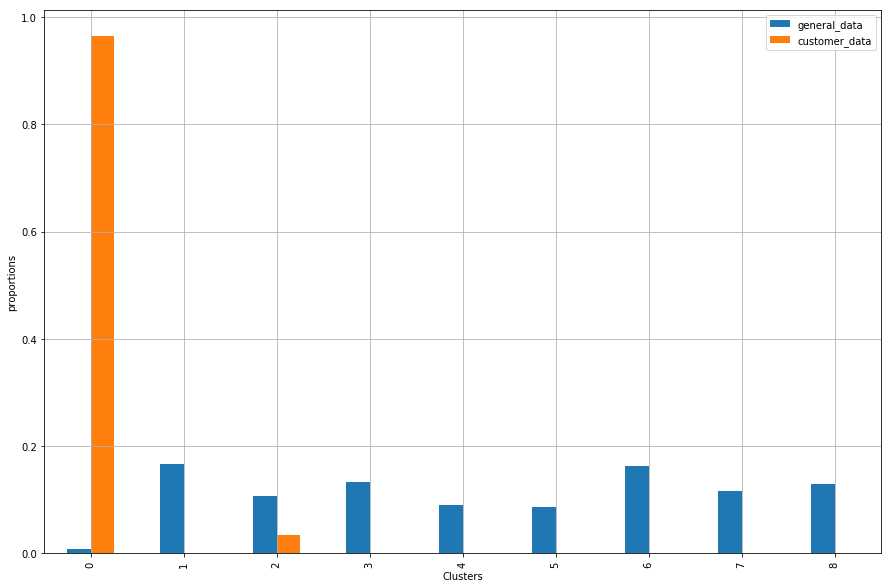

In [80]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

general_data=[]
customer_data=[]
x=[i+1 for i in range(9)]
#for the 15 clusters
for i in range(9):
    general_data.append((kmeans_model_1==i).sum()/len(kmeans_model_1))
    customer_data.append((kmeans_model_customers==i).sum()/len(kmeans_model_customers))
    
data_prop_vis=pd.DataFrame({'cluster':x,'general_data':general_data,'customer_data':customer_data})

#plot
data_prop_vis.plot(y=['general_data','customer_data'],kind='bar',figsize=(15,10))

plt.xlabel('Clusters')
plt.ylabel('proportions')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [81]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster_ov=kmeans.cluster_centers_[0]
cluster_ov=pd.Series(cluster_ov)
cluster_ov.sort_values(ascending=False,inplace=True)
sect_1=cluster_ov.index[0]+1
sect_2=cluster_ov.index[1]+1
sect_3=cluster_ov.index[2]+1

print("The 3 top pc are component {}, component {}, component {}".format(sect_1,sect_2,sect_3))


The 3 top pc are component 17, component 12, component 18


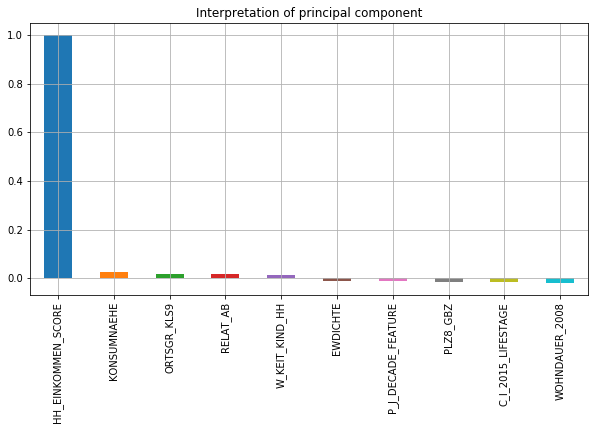

In [82]:
#vizualizing the components
sect=interpret_pc(customers_scaled,pca,17)

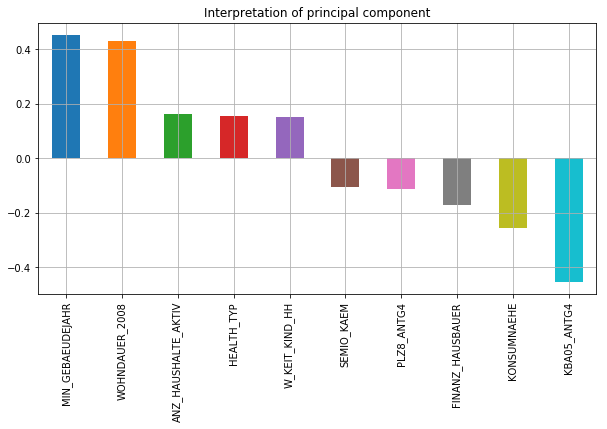

In [83]:
sect=interpret_pc(customers_scaled,pca,12)

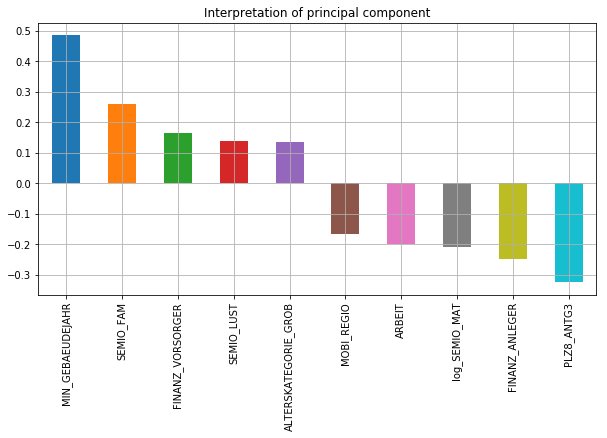

In [84]:
sect=interpret_pc(customers_scaled,pca,18)

In [85]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cluster_un=kmeans.cluster_centers_[2]
cluster_un=pd.Series(cluster_un)
cluster_un.sort_values(ascending=False,inplace=True)
sect_4=cluster_un.index[0]+1
sect_5=cluster_un.index[1]+1
sect_6=cluster_un.index[2]+1

print("The 3 top pc are component {}, component {}, component {}".format(sect_4,sect_5,sect_6))



The 3 top pc are component 1, component 9, component 4


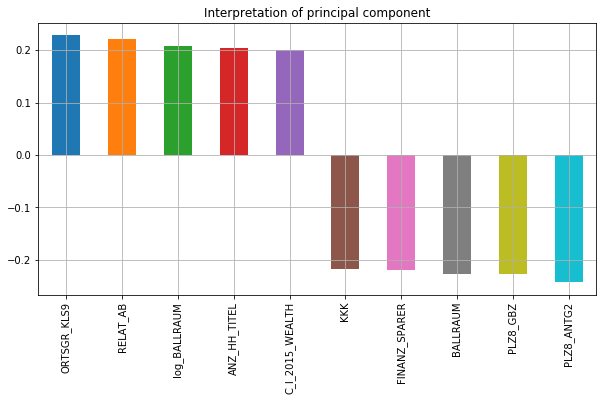

In [86]:
sect=interpret_pc(customers_scaled,pca,1)

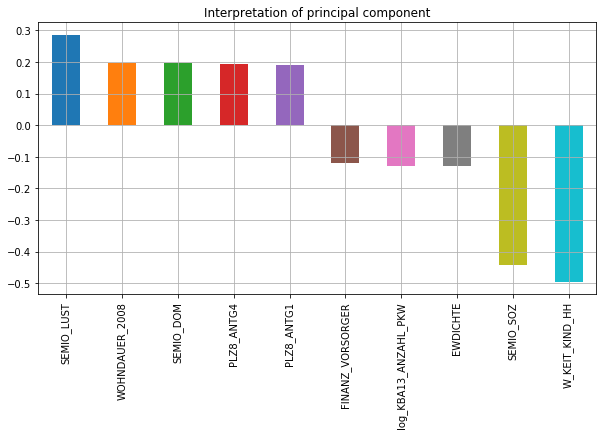

In [87]:
sect=interpret_pc(customers_scaled,pca,9)

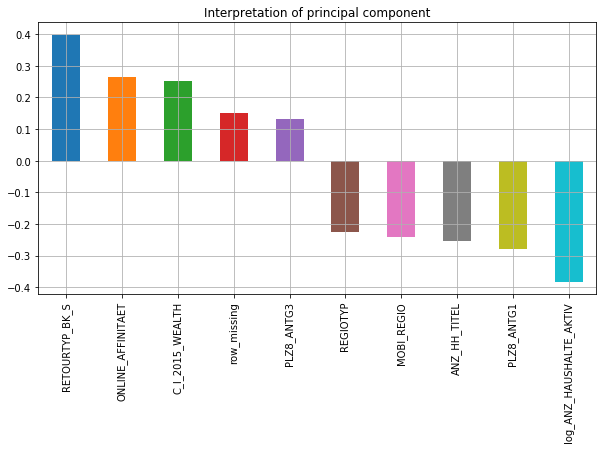

In [88]:
sect=interpret_pc(customers_scaled,pca,4)

### Discussion 3.3: Compare Customer Data to Demographics Data

**First of all, the model in use has been clustered into 9 clusters (ranging from 0-8). 2 clusters are showing the relationship for the overrepresented and underrepresented groups respectively.**

**For the segments of the population that are relatively popular with the mail-order company; they are of the following characteristics: higher estimated household net income with a longer residence in the given area and are also family minded hence a larger household size.**

**For the segments of the population that are relatively unpopular with the mail-order company; they are of the following characteristics: have a higher share of unemployment, living in dense communities, their return type monetary is not conservative and have a higher online affinity.**